In [1]:
# Sam was here
# Jan 17 2021
# Srahbar12@hotmail.com
# Humai Corp.

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [8]:
# Reading the dataset
df = pd.read_csv("/home/sam/Desktop/supervised_rnn/RNN/dataset/supervised_rnn_data.csv")

In [9]:
# Getting rid of the missing values

In [10]:
df.dropna(axis=0, how='any', inplace=True)
df.head()

,0,1,2,3,state,user_id
0,0.3352,0.318315,0.324058,0.931736,A,0
1,0.3352,0.318315,0.324058,0.931736,A,0
2,0.3352,0.318315,0.324058,0.931736,A,0
3,0.3352,0.318315,0.324058,0.931736,A,0
4,0.3352,0.318315,0.324058,0.931736,A,0


In [11]:
# Getting a sense of data by checking the distributiuon of the states and user counts 

In [12]:
print("Dataset shape " + str(df.shape))

Dataset shape (99720, 6)


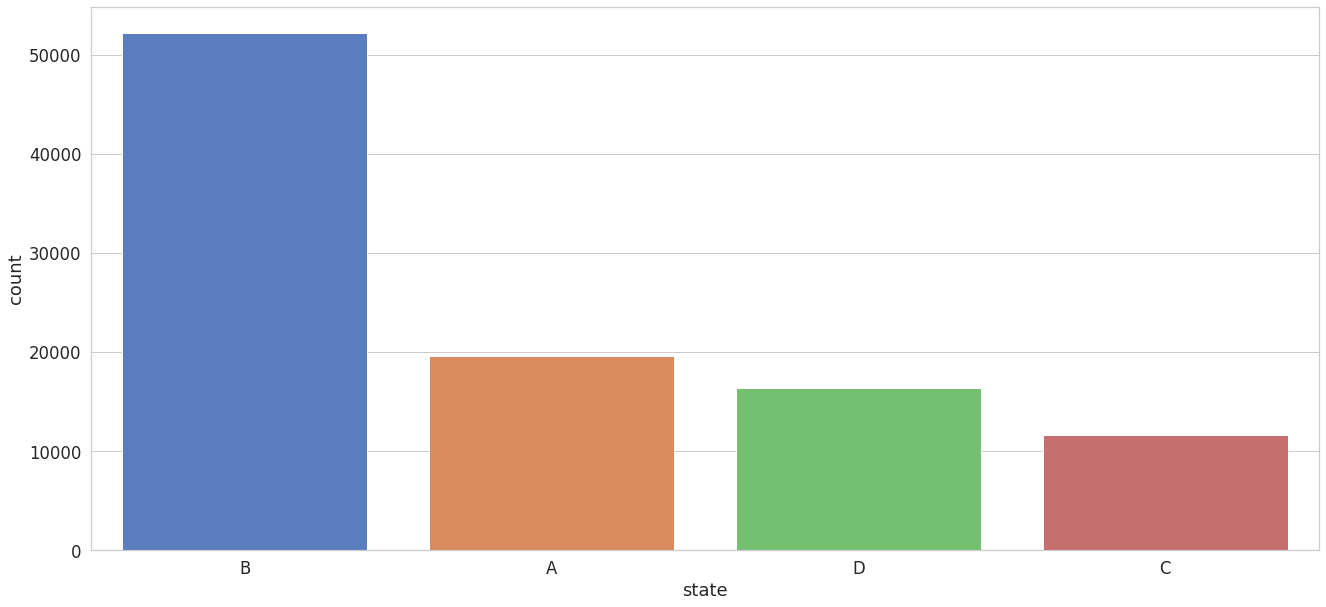

In [13]:
sns.countplot(x = 'state',
              data = df,
              order = df.state.value_counts().index);

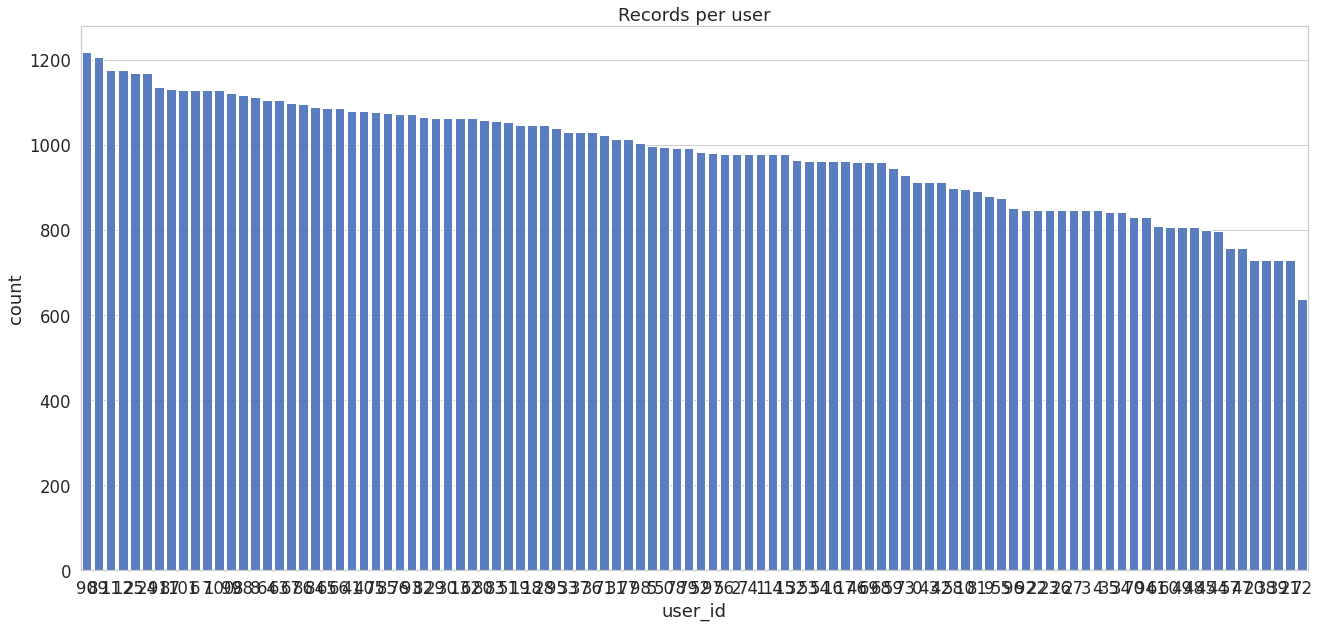

In [14]:
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index);
plt.title("Records per user");

In [55]:
# We now further investigate the dataset by a break down overview of the features (0, 1, 2, 3) 
# and see how their distributions are absed on different states

In [16]:
def plot_state_breakDown(state, df):
    data = df[df['state'] == state][['0', '1', '2','3']][:119]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=state)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

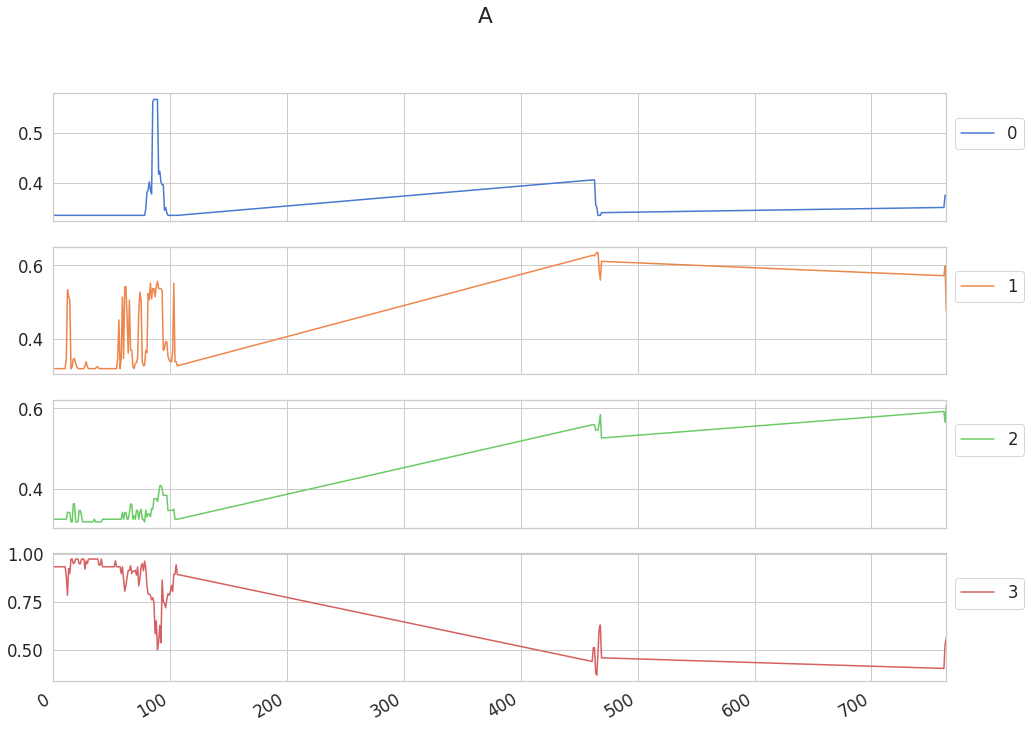

In [17]:
plot_state_breakDown("A", df);

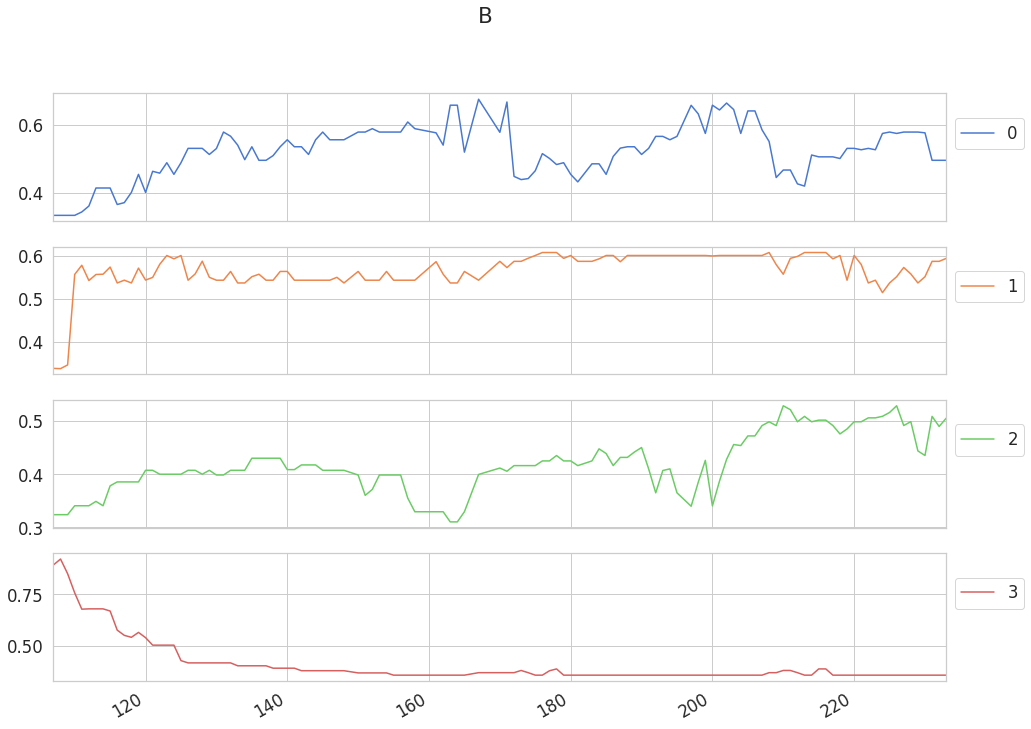

In [18]:
plot_state_breakDown("B", df);

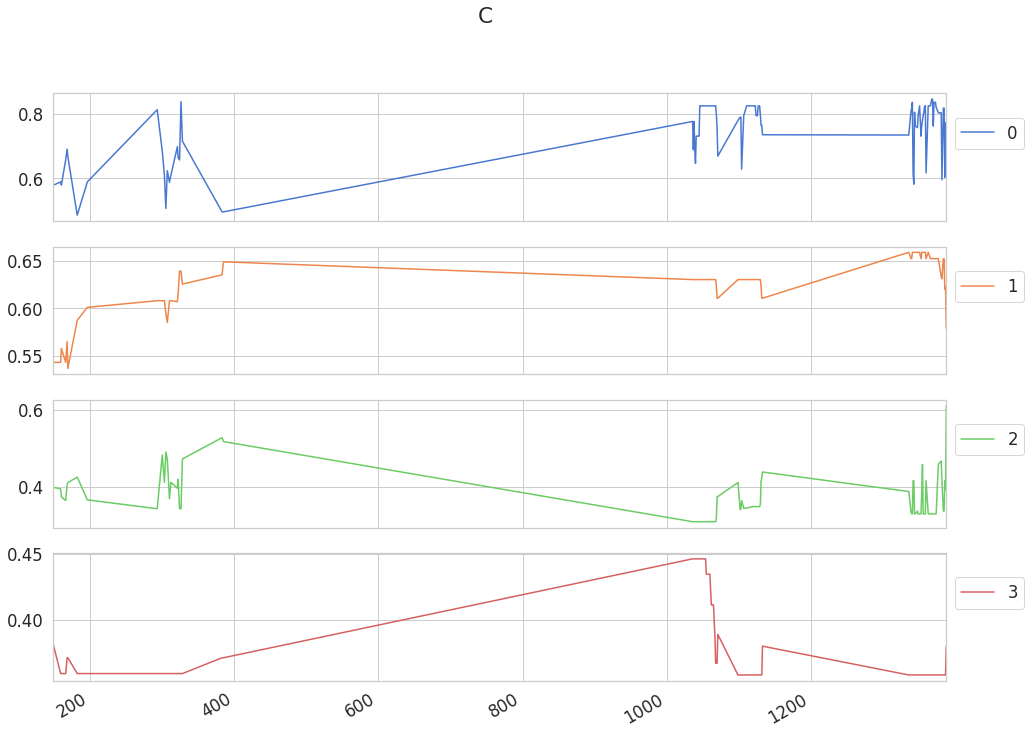

In [19]:
plot_state_breakDown("C", df);

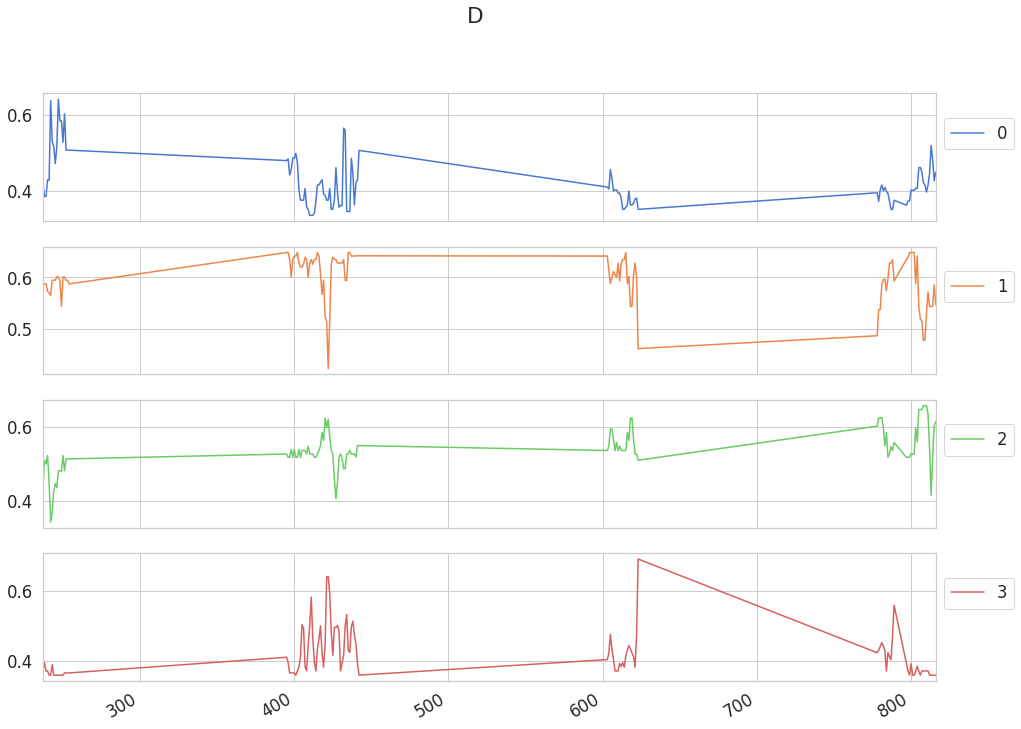

In [20]:
plot_state_breakDown("D", df);

In [21]:
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]

In [44]:
# We now scale up the features for a more robust dataset

In [22]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['0', '1', '2', '3']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

In [23]:
# Method to create the dataset based on the TIME_STEPS 
# Creating training and test sets and labels

In [24]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 119
STEP = 40

X_train, y_train = create_dataset(
    df_train[['0', '1', '2', '3']], 
    df_train.state, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['0', '1', '2', '3']], 
    df_test.state, 
    TIME_STEPS, 
    STEP
)

In [25]:
print(X_train.shape, y_train.shape)

(758, 119, 4) (758, 1)


In [26]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [27]:
print(X_train.shape, y_train.shape)

(758, 119, 4) (758, 4)


In [ ]:
# Creating the model using relu activation this time

In [28]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)




model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

1 Physical GPUs, 1 Logical GPUs


In [29]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=1000,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 1.3893 - acc: 0.2405 - val_loss: 1.3216 - val_acc: 0.4342
Epoch 2/20
1/1 [==============================] - 0s 62ms/step - loss: 1.2904 - acc: 0.4560 - val_loss: 1.2422 - val_acc: 0.6447
Epoch 3/20
1/1 [==============================] - 0s 62ms/step - loss: 1.2076 - acc: 0.6261 - val_loss: 1.1679 - val_acc: 0.6974
Epoch 4/20
1/1 [==============================] - 0s 60ms/step - loss: 1.1333 - acc: 0.6862 - val_loss: 1.0954 - val_acc: 0.7368
Epoch 5/20
1/1 [==============================] - 0s 62ms/step - loss: 1.0634 - acc: 0.7067 - val_loss: 1.0201 - val_acc: 0.7895
Epoch 6/20
1/1 [==============================] - 0s 57ms/step - loss: 0.9977 - acc: 0.7273 - val_loss: 0.9384 - val_acc: 0.8421
Epoch 7/20
1/1 [==============================] - 0s 57ms/step - loss: 0.9376 - acc: 0.7390 - val_loss: 0.8459 - val_acc: 0.8816
Epoch 8/20
1/1 [==============================] - 0s 58ms/step - loss: 0.8687 - acc: 0.7405 - val_l

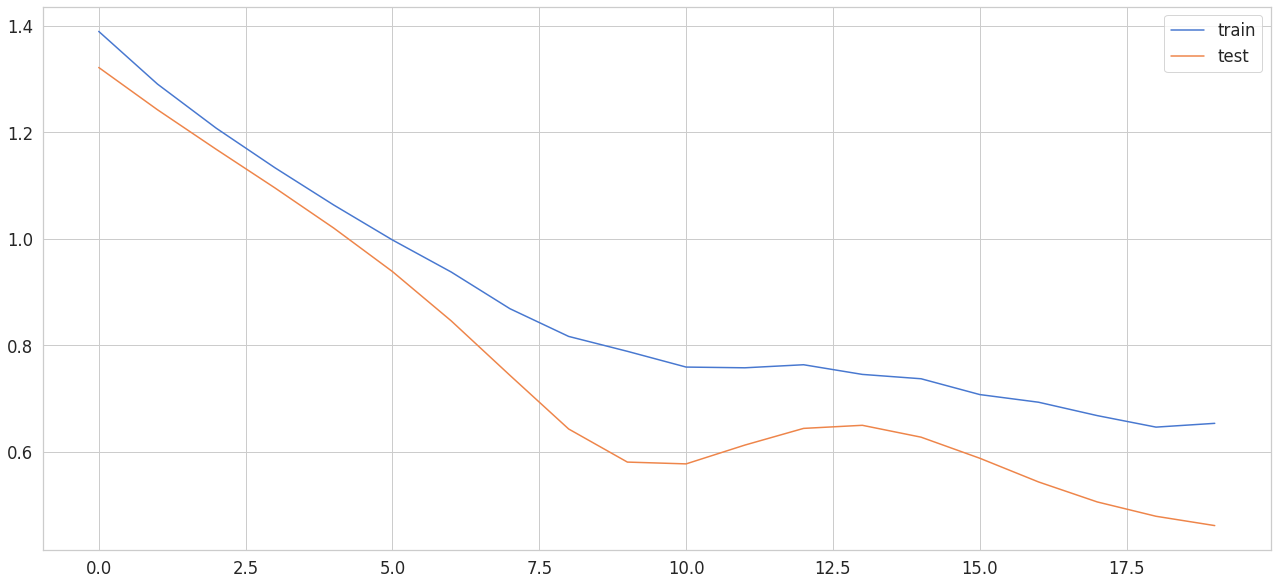

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [31]:
model.evaluate(X_test, y_test)

55/55 [==============================] - 0s 8ms/step - loss: 0.9904 - acc: 0.6757


[0.9903836846351624, 0.6757225394248962]

In [32]:
y_pred = model.predict(X_test)

In [33]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

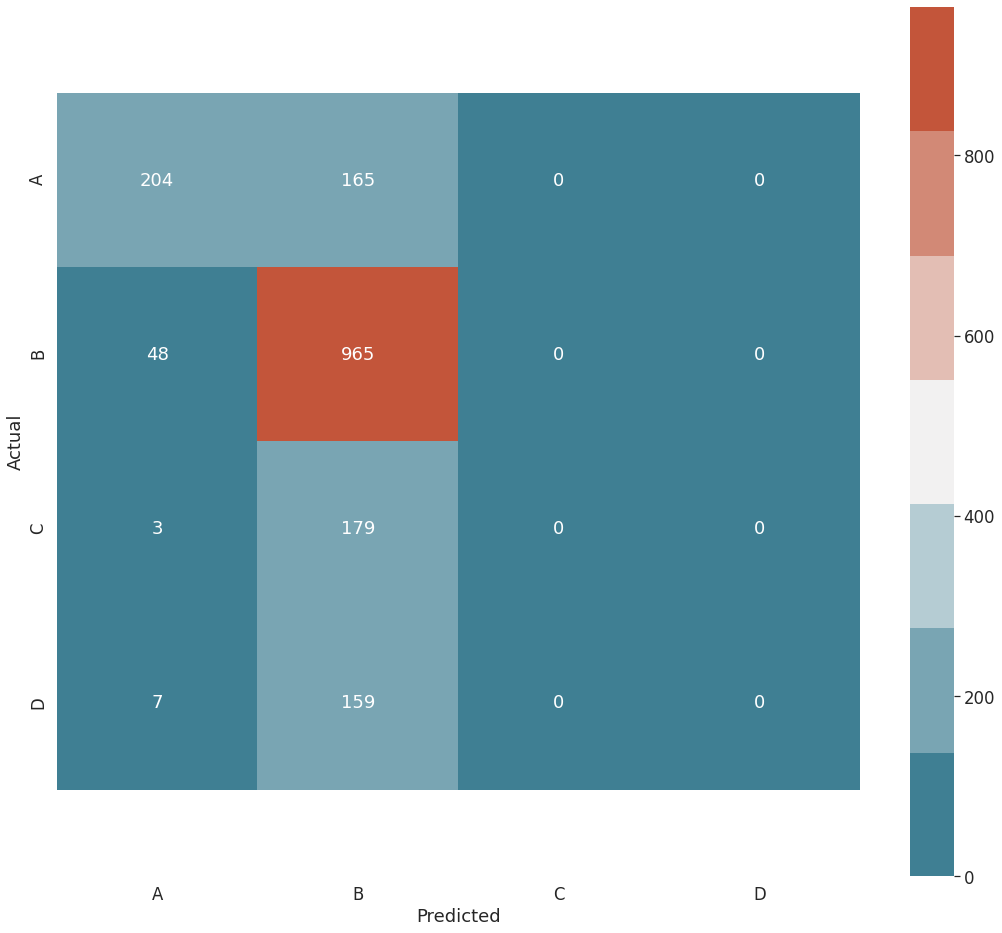

In [34]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

In [35]:
# We now chnage the activation to leaky relu and see the changes

In [37]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)




model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

1 Physical GPUs, 1 Logical GPUs


In [42]:
history2 = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=1000,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/20
1/1 [==============================] - 0s 83ms/step - loss: 0.6539 - acc: 0.7815 - val_loss: 0.4845 - val_acc: 0.8553
Epoch 2/20
1/1 [==============================] - 0s 61ms/step - loss: 0.6378 - acc: 0.7918 - val_loss: 0.4661 - val_acc: 0.8553
Epoch 3/20
1/1 [==============================] - 0s 61ms/step - loss: 0.6220 - acc: 0.7859 - val_loss: 0.4534 - val_acc: 0.8553
Epoch 4/20
1/1 [==============================] - 0s 62ms/step - loss: 0.6298 - acc: 0.7933 - val_loss: 0.4493 - val_acc: 0.8553
Epoch 5/20
1/1 [==============================] - 0s 60ms/step - loss: 0.6015 - acc: 0.7933 - val_loss: 0.4576 - val_acc: 0.8421
Epoch 6/20
1/1 [==============================] - 0s 57ms/step - loss: 0.6056 - acc: 0.7991 - val_loss: 0.4794 - val_acc: 0.8421
Epoch 7/20
1/1 [==============================] - 0s 58ms/step - loss: 0.6035 - acc: 0.8079 - val_loss: 0.4954 - val_acc: 0.8421
Epoch 8/20
1/1 [==============================] - 0s 57ms/step - loss: 0.5912 - acc: 0.8109 - val

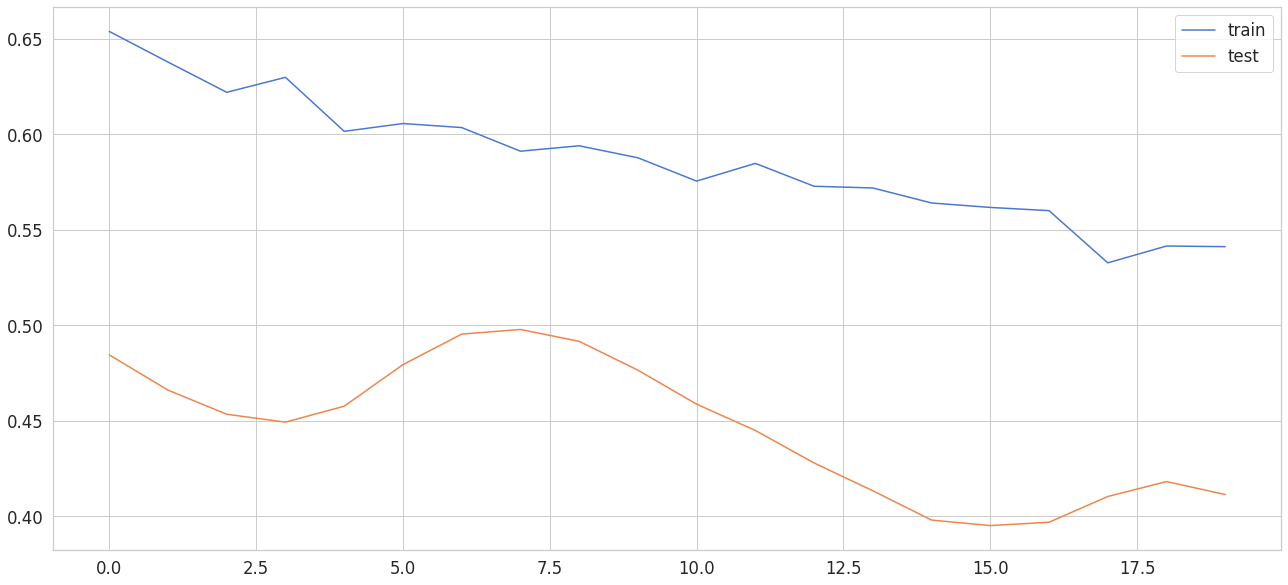

In [45]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend();

In [46]:
model.evaluate(X_test, y_test)

55/55 [==============================] - 0s 7ms/step - loss: 0.9768 - acc: 0.6803


[0.9768297076225281, 0.6803468465805054]

In [47]:
y_pred = model.predict(X_test)

In [48]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

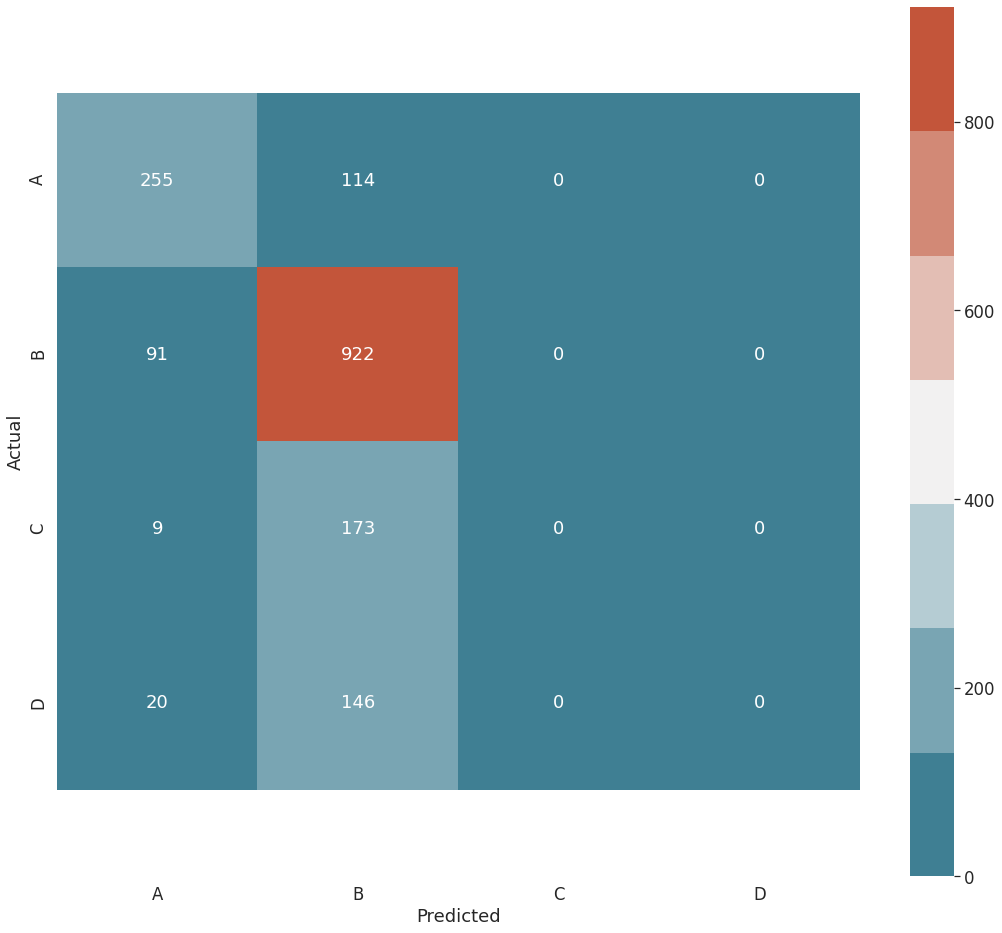

In [49]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

# Relu and LeakyReLU

The Relu and Leaky Relue usage is upon use case. In terms of computations LeakyReLU is faster to compute/
Additionally ReLU sometimes leads to dead neuron problem, 
leaky ReLU overcomes that. For ReLU, the function is f(x) = max(0,x). So ReLU takes zero value when the input values are negative.
While training a deep neural network, during backpropagation stage, zero values' gradient descents become zero again and they do not converge to good local minimum.
It is a dead end situation. Leaky ReLU substitutes zero values with some small value say 0.001 (referred as “alpha”). So, for leaky ReLU, the function f(x) = max(0.001x, x). 
Now gradient descent of 0.001x will be having a non-zero value and it will continue learning without reaching dead end. Hence, leaky ReLU performs better than ReLU.

But again this is general and this activation depends on the model and use case. In our case LeakyRelu seems
to perform better in terms of computaitons and accuracy

# If I has more time I would experiment with
#1- The learning rate (adaptive learning rate)
#2- The Gradient Clipping
#2.1- Better regularization
#3- Truncated backpropagation
#4- Augmenting the dataset and longer training run
#5- Possibly a multi-step loss